In [2]:
pip install praw

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install vaderSentiment

Note: you may need to restart the kernel to use updated packages.


In [6]:
import praw
import pandas as pd
import time
import re

# Reddit API authentication
reddit = praw.Reddit(
    client_id="G6K9J-lc62BLR2DEAvWKBQ",         # Client ID
    client_secret="NSSd56XGPEuY9FlhxnReQW36oJR4xg",  # Client Secret
    user_agent="corpus_project (by /u/AnyDeer1096)"  # User Agent
)


In [8]:
# Define target subreddits and keywords
subreddits = ['LGBT', 'AskReddit', 'Conservative']
keywords = ["queer", "faggot", "dyke", "gay", "homo"]

# Calculate Unix timestamp for 5 years ago
five_years_ago = int(time.time()) - (5 * 365 * 24 * 60 * 60)  # Approximate for leap years


In [10]:
# Function to scrape comments for each subreddit
def scrape_comments(subreddit, keywords, comment_limit=1000):
    comments_data = []  # Initialize a list to store comment data
    subreddit_instance = reddit.subreddit(subreddit)
    
    total_comments = 0  # Counter for comments
    
    for keyword in keywords:
        print(f"Searching comments for keyword '{keyword}' in subreddit '{subreddit}'...")
        for submission in subreddit_instance.search(keyword, time_filter="all", limit=comment_limit):
            # Process comments in each submission
            submission.comments.replace_more(limit=0)  # Expand comments
            for comment in submission.comments.list():
                if total_comments >= comment_limit:
                    break  # Stop if the limit is reached
                print(f"Found comment: {comment.body[:50]}")  # Debugging print
                comments_data.append({
                    'subreddit': subreddit,
                    'keyword': keyword,
                    'body': comment.body,
                    'created_utc': comment.created_utc,
                    'score': comment.score,
                    'parent_id': comment.parent_id,
                    'submission_id': submission.id,
                    'type': 'comment'
                })
                total_comments += 1
            
            if total_comments >= comment_limit:
                break  # Stop processing further submissions if comment limit is reached
        
        if total_comments >= comment_limit:
            break  # Stop processing further keywords if comment limit is reached

    print(f"Scraping comments complete: {total_comments} comments collected for subreddit '{subreddit}'.")
    return pd.DataFrame(comments_data)

# Scrape comments for all subreddits in the list
comments_all = pd.concat(
    [scrape_comments(sub, keywords, comment_limit=1000) for sub in subreddits],
    ignore_index=True
)

# Save the comments data to a CSV file
comments_all.to_csv('reddit_comments.csv', index=False)
print(f"Total comments collected: {len(comments_all)}")

              

Searching comments for keyword 'queer' in subreddit 'LGBT'...
Found comment: Thank you for your post, if this is a question ple
Found comment: For me it means I am not cis and I’m not straight 
Found comment: i use it as a general umbrella term for the entire
Found comment: I use "queer" once the acronym surpasses five char
Found comment: The beauty of ‘queer’ is in its flexibility. It ca
Found comment: For me it's sort of "all of the above/other"
Found comment: I like the term because of how inclusive it is. Es
Found comment: Queer used to be used an and insult to the LGBTQIA
Found comment: I use it because I'm unsure of a label and my sexu
Found comment: I use queer cause it's less restrictive as a label
Found comment: Queer means any of the following or a combination 
Found comment: My favorite way is: oh he's a friend of Dorothy. 

Found comment: queer, to me, describes anyone who is not cis-hete
Found comment: I consider it a slur so I don’t use it at all.
Found comment: I use it 

In [12]:
comments_all[['keyword', 'body', 'subreddit']].to_csv('reddit_comments_filtered.csv', index=False)
print("Filtered comments saved to 'reddit_comments_filtered.csv'")


Filtered comments saved to 'reddit_comments_filtered.csv'


In [15]:
# Function to scrape posts for each subreddit
def scrape_posts(subreddit, keywords, post_limit=1000):
    posts_data = []  # Initialize a list to store post data
    subreddit_instance = reddit.subreddit(subreddit)
    
    total_posts = 0  # Counter for posts
    
    for keyword in keywords:
        print(f"Searching posts for keyword '{keyword}' in subreddit '{subreddit}'...")
        for submission in subreddit_instance.search(keyword, time_filter="all", limit=post_limit):
            if total_posts >= post_limit:
                break  # Stop if the limit is reached
            print(f"Found post: {submission.title[:50]}")  # Debugging print
            posts_data.append({
                'subreddit': subreddit,
                'keyword': keyword,
                'post': submission.title + ' ' + submission.selftext  # Combine title and selftext
            })
            total_posts += 1
        
        if total_posts >= post_limit:
            break  # Stop processing further keywords if post limit is reached

    print(f"Scraping posts complete: {total_posts} posts collected for subreddit '{subreddit}'.")
    return pd.DataFrame(posts_data)

# Scrape posts for all subreddits in the list
posts_all = pd.concat(
    [scrape_posts(sub, keywords, post_limit=1000) for sub in subreddits],
    ignore_index=True
)

# Save posts to a CSV file
posts_all[['keyword', 'post', 'subreddit']].to_csv('reddit_posts_filtered.csv', index=False)
print("Filtered posts saved to 'reddit_posts_filtered.csv'")


Searching posts for keyword 'queer' in subreddit 'LGBT'...
Found post: What does “queer” mean anyway?
Found post: Elon Musk’s transgender daughter, in first intervi
Found post: I am your queer bartender! What are you ordering? 
Found post: I am a queer trans man and my boyfriend is a gay c
Found post: I just reread a few of the deadpool and spider-man
Found post: Which cartoon character turned you queer? 
Found post: I think I may have realized the US Gov’s plan to k
Found post: Petition to make opera gx the official queer brows
Found post: Today in Roanoke, Texas armed queer folk and allie
Found post: Bisexuals belong in queer spaces
Found post: The First Song You Can Think of That is "Queer Cul
Found post: What is the worst example of queer bait you've see
Found post: Sent my mom this meme and she yelled "I can be hom
Found post: Is it homophobic to say you don’t want a queer chi
Found post: What flavor of queer are Jessie and James?
Found post: Question: why aren’t more young people

In [18]:
import pandas as pd

# Read the two CSV files
comments_df = pd.read_csv('reddit_comments_filtered.csv')
posts_df = pd.read_csv('reddit_posts_filtered.csv')

# Add a column to indicate the data type
comments_df['type'] = 'comment'
posts_df['type'] = 'post'

# Combine the dataframes
combined_df = pd.concat([comments_df, posts_df], ignore_index=True)

# Sort by subreddit
combined_df = combined_df.sort_values(by='subreddit')

# Split data by subreddit
subreddits = combined_df['subreddit'].unique()

# Save each subreddit data to a separate .txt file in corpus style
for subreddit in subreddits:
    subreddit_data = combined_df[combined_df['subreddit'] == subreddit]
    
    # Combine 'body' and 'post' columns, keeping only the text
    text_data = subreddit_data[['body', 'post']].fillna('').apply(
        lambda x: f"{x['body'] or x['post']}", axis=1
    )
    
    # Join all text entries into a single string separated by line breaks
    corpus_text = "\n".join(text_data.tolist())
    
    # Save to a .txt file
    with open(f"{subreddit}_corpus.txt", "w", encoding="utf-8") as file:
        file.write(corpus_text)

print("Subreddit data saved in AntConc-compatible .txt files.")



Subreddit data saved in AntConc-compatible .txt files.


In [20]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to compute sentiment scores
def analyze_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return None  # Handle missing or empty text
    sentiment_scores = analyzer.polarity_scores(text)
    return sentiment_scores['compound']  # Return compound score for overall sentiment

# Apply sentiment analysis to the combined data
combined_df['sentiment_score'] = combined_df['post'].apply(analyze_sentiment)

# Categorize sentiment
def categorize_sentiment(score):
    if score is None:
        return 'Neutral'
    elif score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Add a sentiment category column
combined_df['sentiment_category'] = combined_df['sentiment_score'].apply(categorize_sentiment)

# Save results to a new CSV file
combined_df.to_csv("reddit_posts_with_sentiment.csv", index=False)
print("Sentiment analysis results saved to 'reddit_posts_with_sentiment.csv'.")


Sentiment analysis results saved to 'reddit_posts_with_sentiment.csv'.


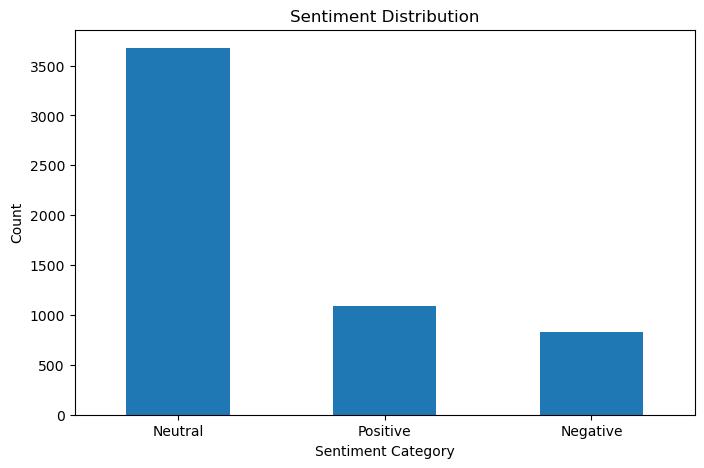

In [22]:
import matplotlib.pyplot as plt

# Count sentiment categories
sentiment_counts = combined_df['sentiment_category'].value_counts()

# Plot bar chart
plt.figure(figsize=(8, 5))
sentiment_counts.plot(kind='bar')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


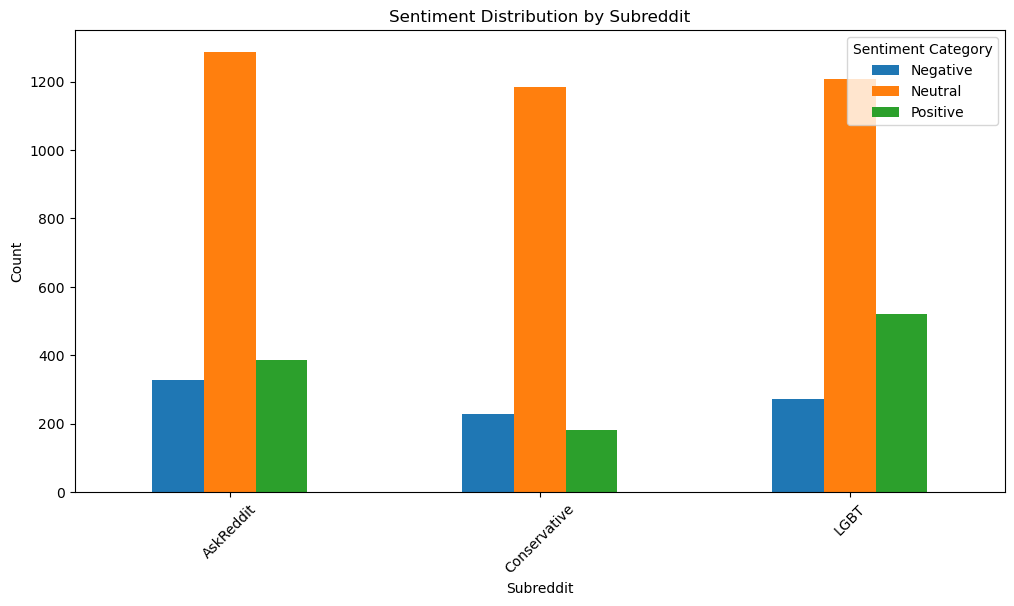

In [24]:
import seaborn as sns

# Group data by subreddit and sentiment category
sentiment_by_subreddit = combined_df.groupby(['subreddit', 'sentiment_category']).size().unstack()

# Plot grouped bar chart
sentiment_by_subreddit.plot(kind='bar', figsize=(12, 6))
plt.title('Sentiment Distribution by Subreddit')
plt.xlabel('Subreddit')
plt.ylabel('Count')
plt.legend(title='Sentiment Category')
plt.xticks(rotation=45)
plt.show()


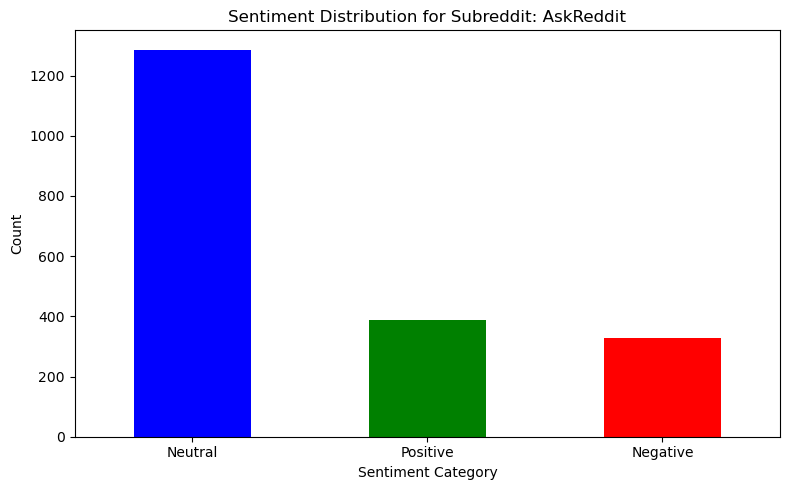

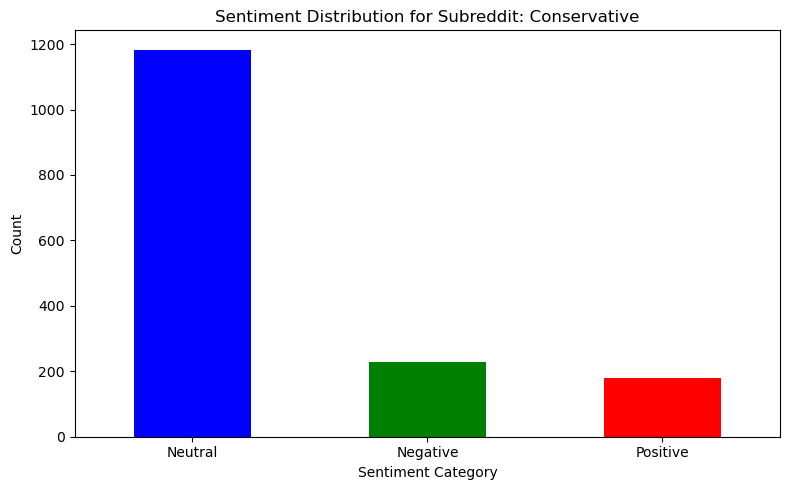

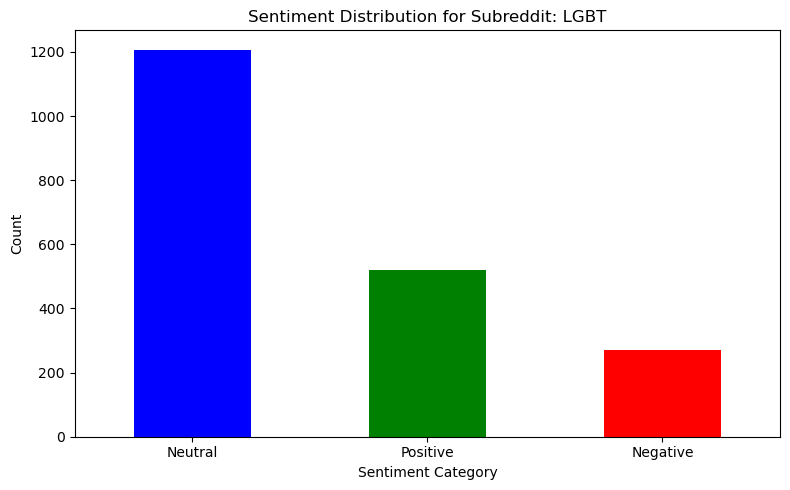

In [26]:
import matplotlib.pyplot as plt

# Group data by subreddit
subreddits = combined_df['subreddit'].unique()

# Create separate sentiment distribution graphs for each subreddit
for subreddit in subreddits:
    # Filter data for the subreddit
    subreddit_data = combined_df[combined_df['subreddit'] == subreddit]
    
    # Count sentiment categories
    sentiment_counts = subreddit_data['sentiment_category'].value_counts()
    
    # Plot sentiment distribution
    plt.figure(figsize=(8, 5))
    sentiment_counts.plot(kind='bar', color=['blue', 'green', 'red'])
    plt.title(f'Sentiment Distribution for Subreddit: {subreddit}')
    plt.xlabel('Sentiment Category')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [ ]:
import praw
import nltk
import pandas as pd
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Example: Setting up Reddit API connection with PRAW
reddit = praw.Reddit(
    client_id='YOUR_CLIENT_ID',
    client_secret='YOUR_CLIENT_SECRET',
    user_agent='YOUR_USER_AGENT'
)

# Example: Sentiment Analysis with VADER
analyzer = SentimentIntensityAnalyzer()
sentiment = analyzer.polarity_scores("This is a sample text")
print(sentiment)